In [4]:
from jax import numpy as np
import scipy
import littlemcmc as lmc
import numpy
import matplotlib.pyplot as plt

from jax import jacfwd, jacrev
from jax import grad, jit, vmap

In [3]:
%matplotlib inline

In [5]:
# reference implementation in numpy
def multiflaremodelnp(t, tpeaks, fwhms, ampls):
    multiflare_lc = np.zeros_like(t)
    npeaks = tpeaks.shape[0]
    for i in range(npeaks):
        flare_lc = flaremodelnp(t, tpeaks[i], fwhms[i], ampls[i])
        multiflare_lc = multiflare_lc + flare_lc
    return multiflare_lc

def flaremodelnp(t, tpeak, fwhm, ampl, oversample=10):
    # reuses some code from AltaiPony and Apaloosa
    _fr = [1.00000, 1.94053, -0.175084, -2.24588, -1.12498]
    _fd = [0.689008, -1.60053, 0.302963, -0.278318]
    flare_lc = np.zeros_like(t)
    flare_lc = np.where((t <= tpeak) * ((t - tpeak)/fwhm > -1.),
                       (_fr[0] +
                        _fr[1] * ((t - tpeak) / fwhm) +
                        _fr[2] * ((t - tpeak) / fwhm)**2. +
                        _fr[3] * ((t - tpeak) / fwhm)**3. +
                        _fr[4] * ((t - tpeak) / fwhm)**4. ) *
                        ampl,
                        flare_lc
                       )
    flare_lc = np.where((t > tpeak) * ((t - tpeak)/fwhm < 20.),
                       (_fd[0] * np.exp( ((t - tpeak) / fwhm)*_fd[1] ) +
                        _fd[2] * np.exp( ((t - tpeak) / fwhm) * _fd[3] )) *
                        ampl,
                        flare_lc
                       )
    return flare_lc

In [136]:
# create some signals
t = np.arange(0,10,2/1440)
tpeaks = numpy.random.choice(t, size=1)
fwhms = numpy.random.random(size=1) / 30
# ampls = numpy.random.random(size=1)*10
ampls = numpy.random.random(size=1)*100

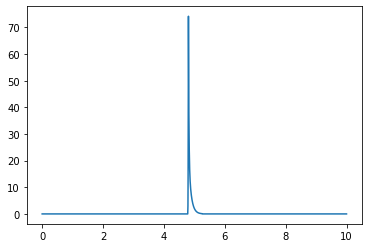

In [137]:
numpy.random.seed = 8675309
jit_mf = jit(multiflaremodelnp)
plt.plot(t, jit_mf(t, tpeaks, fwhms, ampls))

In [138]:
x = numpy.copy(t)
y = jit_mf(t, tpeaks, fwhms, ampls) + numpy.random.normal(size=np.shape(x)[0])

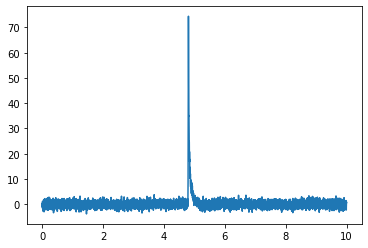

In [139]:
plt.plot(x, y)

In [178]:
def logp_func(X):
#     x, y = args
    ampls = X
    model = flaremodelnp(x, tpeaks, fwhms, ampls)
    return np.sum((y-model)**2)


# def dlogp_func(x, loc=0, scale=1):
#     return -(x - loc) / scale

dlogp_func = grad(logp_func)


def logp_dlogp_func(X):
    return logp_func(X), dlogp_func(X)

In [180]:
print(logp_func(30.))
print(dlogp_func(30.))

30342.445
nan


In [111]:
args = x, y

trace, stats = lmc.sample(
    logp_dlogp_func=logp_dlogp_func,
    start=tpeaks,
    size=1,
    draws=1000,
    tune=500,
    step=lmc.NUTS(logp_dlogp_func=logp_dlogp_func, size=1),
    chains=1,
    cores=1,
    random_seed=[None],
    progressbar=None  # HTML progress bars don't render well in RST.
)

ValueError: Bad initial energy: nan. The model might be misspecified.

In [181]:
def logp_func(x, loc=0, scale=1):
    return np.log(scipy.stats.norm.pdf(x, loc=loc, scale=scale))


def dlogp_func(x, loc=0, scale=1):
    return -(x - loc) / scale


def logp_dlogp_func(x, loc=0, scale=1):
    return logp_func(x, loc=loc, scale=scale), dlogp_func(x, loc=loc, scale=scale)

In [191]:


trace, stats = lmc.sample(
    logp_dlogp_func=logp_dlogp_func,
    size=1,
    draws=1000,
    tune=500,
    step=lmc.NUTS(logp_dlogp_func=logp_dlogp_func, size=1),
    chains=2,
    cores=1,
    random_seed=[None],
#     progressbar=None  # HTML progress bars don't render well in RST.
)

100%|██████████| 1500/1500 [00:10<00:00, 138.17it/s]


(array([  3.,  10.,  49., 120., 235., 256., 210.,  79.,  27.,  11.]),
 array([-3.71149986, -3.02266784, -2.33383582, -1.6450038 , -0.95617179,
        -0.26733977,  0.42149225,  1.11032427,  1.79915629,  2.4879883 ,
         3.17682032]),
 <a list of 10 Patch objects>)

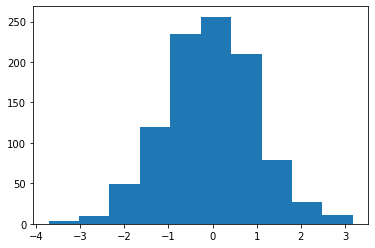

In [192]:
plt.hist(trace)